In [1]:
import datetime
import os
from pathlib import Path

import laspy
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
import torch
import geopandas as gpd
import py4dgeo
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import pipeline

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Debuging Parameters

In [2]:
log_dir = f"outputs/{datetime.datetime.now().strftime('%Y%m%d-%H%M')}"
nth = 1

os.makedirs(log_dir, exist_ok=True)
print(f"Logging to {log_dir}")
print(f"Plotting every {nth}th point")

Logging to outputs/20250522-0116
Plotting every 1th point


### Parameters

In [ ]:
input_file = "datasets/WHU/3-Mountain/combined.las"
las = laspy.read(input_file)
x = las.x
y = las.y
z = las.z

shp_file = "datasets/WHU/3-Mountain/combined_stable.shp"
satble_shp = gpd.read_file(shp_file)

In [4]:
center_x = np.mean(x) + 15 # Center x of deformation
center_y = np.mean(y) + 15 # Center y of deformation
radius = 5                 # Radius of the mining region
max_depth = 3              # Maximum depth at the center
sigma = radius / 2.0       # Spread of the deformation
noise_std = 0.1            # Noise standard deviation in meters

angle_x_deg = 0.4    # Rotation around x-axis in degrees
angle_y_deg = 0.1    # Rotation around y-axis in degrees
angle_z_deg = 17.5   # Rotation around z-axis in degrees
translation_x = 10.0 # Translation along x-axis in meters
translation_y = -5.0 # Translation along y-axis in meters
translation_z = 0.2  # Translation along z-axis in meters

DEVICE = torch.device("cuda:{}".format(0))
PADDING = "same"
VOXEL_SIZE = 2.0
PV = 5
NV = -1
PPV = -1
NUM_WORKERS = 24
ROTATION_CHOICE = "gen"

QUANTILE_THR = 0.2
ICP_VERSION = "generalized"
MAX_ITER = 2048

In [5]:
analytical_volume = pipeline.get_analytical_volume(sigma, radius, max_depth)
print("Analytical ground truth volume removed (m^3):", analytical_volume)

rot = 45
tas = 10
T = pipeline.get_random_transformation(
    angle_range_z=((-rot - 2.5, -rot + 2.5), (rot - 2.5, rot + 2.5)),
    translation_range=((-tas - 0.5, -tas + 0.5), (tas - 0.5, tas + 0.5)),
)
print("Ground truth transformation matrix (4x4):", "\n", np.linalg.inv(T))

Analytical ground truth volume removed (m^3): 101.86591207508087
Ground truth transformation matrix (4x4): 
 [[ 7.22914725e-01 -6.86612852e-01 -7.71822061e-02  1.34446730e+01]
 [ 6.89268633e-01  7.24413997e-01  1.15374203e-02 -6.65505281e-01]
 [ 4.79901294e-02 -6.15398447e-02  9.96950247e-01  1.09792967e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


### Pseudo data generator for the WHU-TLS Mountain scan

In [6]:
z_deformed, mask = pipeline.apply_deformation(x, y, z, center_x, center_y, radius, max_depth, sigma)
x_noisy, y_noisy, z_noisy = pipeline.apply_noise(x, y, z_deformed, noise_std)
x_trans, y_trans, z_trans = pipeline.apply_transformation(x_noisy, y_noisy, z_noisy, T)

In [7]:
new_header = laspy.LasHeader(point_format=las.header.point_format, version=las.header.version)
new_header.scales = las.header.scales
new_header.offsets = las.header.offsets

new_las = laspy.LasData(new_header)
new_las.x = x_trans
new_las.y = y_trans
new_las.z = z_trans

new_las.write(f"{log_dir}/alt.las")

### Registration wit EGS

In [9]:
source = np.vstack((x_trans, y_trans, z_trans)).transpose()
target = np.vstack((x, y, z)).transpose()

In [10]:
EGS_T = pipeline.EGS(
    source=source,
    target=target,
    voxel_size=VOXEL_SIZE,
    padding=PADDING,
    ppv=PPV,
    pv=PV,
    nv=NV,
    num_workers=NUM_WORKERS,
    rotation_choice=ROTATION_CHOICE,
    rotation_root_path="exhaustive-grid-search/data/rotations",
)

FFT Convolution: 100%|██████████| 1656/1656 [04:41<00:00,  5.89it/s]


In [11]:
GICP_T = pipeline.auto_GICP(
    source=source, target=target, T_init=EGS_T, thr=QUANTILE_THR, max_iter=MAX_ITER
)

0.15645051680480818


In [12]:
gt = np.linalg.inv(T)

rre_one = pipeline.compute_rre(np.eye(4,4), gt)
rte_one = pipeline.compute_rte(np.eye(4,4), gt)
print(rre_one)
print(rte_one)

rre = pipeline.compute_rre(EGS_T, gt)
rte = pipeline.compute_rte(EGS_T, gt)
print("Rotation error (degrees):", rre)
print("Translation error (m):", rte)

rre_refined = pipeline.compute_rre(GICP_T, gt)
rte_refined = pipeline.compute_rte(GICP_T, gt)
print("Refined rotation error (degrees):", rre_refined)
print("Refined translation error (m):", rte_refined)

43.76859609832777
17.370868842031438
Rotation error (degrees): 0.8455935190961478
Translation error (m): 2.318957755528788
Refined rotation error (degrees): 0.01091307169176803
Refined translation error (m): 0.015194400145417066


In [13]:
x_refined, y_refined, z_refined = pipeline.apply_transformation(x_trans, y_trans, z_trans, GICP_T)
refined = np.vstack((x_refined, y_refined, z_refined)).transpose()

### Change Detection

```bash
git submodule update --init --recursive
cd py4dgeo
python -m pip install -v --editable .
```

In [14]:
stable_before, mask_before = pipeline.isolate_stable(target, satble_shp)
stable_after,  mask_after  = pipeline.isolate_stable(refined, satble_shp)

epoch_stabel_before = py4dgeo.Epoch(stable_before)
epoch_stabel_after  = py4dgeo.Epoch(stable_after)

In [15]:
epoch_stabel_after.build_kdtree()
indices, distances = epoch_stabel_after.kdtree.nearest_neighbors(
    epoch_stabel_before.cloud, 1
)
distances = np.sqrt(distances)

print(f"C2C Median distances: {np.median(distances):.3f} m")
print(f"C2C Std. dev. of distances: {np.std(distances):.3f} m")
print(f"C2C max of distances: {np.max(distances):.3f} m")

[2025-05-22 01:27:44][INFO] Building KDTree structure with leaf parameter 10
C2C Median distances: 0.047 m
C2C Std. dev. of distances: 0.023 m
C2C max of distances: 0.438 m


In [16]:
avg_spacing = pipeline.estimate_avg_spacing(target)
print("Estimated average spacing:", avg_spacing)

# Define a target downsampling ratio (e.g., retain 10% of points)
ref_ratio = 0.01
init_voxel_size = avg_spacing / ref_ratio

# Adaptively determine the voxel size
adapted_voxel_size = pipeline.adaptive_voxel_size(target, ref_ratio, init_voxel_size, 25, 15, 1)
print("Adapted voxel size:", adapted_voxel_size)

# Downsample using the final voxel size
down_source = pipeline.voxel_downsample(target, adapted_voxel_size)
print(f"Original points: {len(target)}, Downsampled points: {len(down_source)}")

Estimated average spacing: 0.01867108123166193
0.0010953209116402551
Voxel size: 4.6472406466230884, error: 0.008904679088359745, scale: 0.9118828584680142
0.00020242174933487629
Voxel size: 4.087145957787245, error: 0.009797578250665124, scale: 0.7834561409742543
0.000254225401053827
Voxel size: 3.477320644742386, error: 0.009745774598946173, scale: 0.6218712919006983
0.00034304622909950825
Voxel size: 2.8677104012214194, error: 0.009656953770900492, scale: 0.42912316610886614
0.0004942761808695947
Voxel size: 2.2979930662065557, error: 0.009505723819130405, scale: 0.20764538643957364
0.0007456972503835179
Voxel size: 1.7944940600927761, error: 0.009254302749616482, scale: -0.03966765412837381
0.0011820002501463733
Voxel size: 1.3705152279989699, error: 0.008817999749853627, scale: -0.3092040276944028
0.001952426605927225
Voxel size: 1.0285511965499075, error: 0.008047573394072775, scale: -0.5962395689135673
0.003335216994330712
Voxel size: 0.7636538704255432, error: 0.006664783005669

In [18]:
m3c2 = py4dgeo.M3C2(
    epochs=(epoch_stabel_before, epoch_stabel_after),
    corepoints=epoch_stabel_before.cloud[::],
    normal_radii=(adapted_voxel_size * 2.0,),
    cyl_radius=(adapted_voxel_size),
    max_distance=(15.0),
    registration_error=(0.0),
)
m3c2_distances_stableparts, uncertainties_stableparts = m3c2.run()
reg_target_source = np.nanstd(m3c2_distances_stableparts)

print(f"M3C2 Median distances: {np.nanmedian(m3c2_distances_stableparts):.3f} m")
print(f"M3C2 Std. dev. of distances: {np.nanstd(m3c2_distances_stableparts):.3f} m")
print(f"Registration error {reg_target_source:.3f} m.")

[2025-05-22 01:29:03][INFO] Building KDTree structure with leaf parameter 10
M3C2 Median distances: -0.000 m
M3C2 Std. dev. of distances: 0.017 m
Registration error 0.017 m.


In [19]:
epoch_before = py4dgeo.Epoch(target)
epoch_after = py4dgeo.Epoch(refined)

corepoints_pcd        = o3d.geometry.PointCloud()
corepoints_pcd.points = o3d.utility.Vector3dVector(epoch_before.cloud)
corepoints_pcd        = corepoints_pcd.voxel_down_sample(voxel_size=adapted_voxel_size)#0.1)
corepoints            = np.asarray(corepoints_pcd.points)

m3c2 = py4dgeo.M3C2(
    epochs=(epoch_before, epoch_after),
    corepoints=corepoints,
    normal_radii=(adapted_voxel_size * 2.0,),
    cyl_radius=(adapted_voxel_size),
    max_distance=(15.0),
    registration_error=(reg_target_source),
)
m3c2_distances, uncertainties = m3c2.run()
change_sign = np.where(abs(m3c2_distances) > uncertainties["lodetection"], True, False)

[2025-05-22 01:29:07][INFO] Building KDTree structure with leaf parameter 10
[2025-05-22 01:29:13][INFO] Building KDTree structure with leaf parameter 10


### Volume Calculation

In [20]:
hulls = pipeline.segment_changes(corepoints, change_sign)

selected_indices    = [np.argmax([hull.area for hull in hulls])]
selected_hulls      = [hulls[i] for i in selected_indices]
inside_mask_refined = pipeline.is_inside_selected_hulls_vectorized(selected_hulls, refined[:, :2])
inside_mask_raw     = pipeline.is_inside_selected_hulls_vectorized(selected_hulls, target[:, :2])

filtered_refined = refined[inside_mask_refined]
filtered_raw     = target[inside_mask_raw]

filtered_refined_x, filtered_refined_y, filtered_refined_z = filtered_refined.T
filtered_raw_x, filtered_raw_y, filtered_raw_z = filtered_raw.T

In [21]:
dem_before, dem_after, dem_grid_x, dem_grid_y, grid_res = pipeline.reletive_DEM(
    filtered_raw,
    filtered_refined,
    grid_res=None,
    method="linear",
    mask_hulls=selected_hulls,
)

net_volume, cut_volume, fill_volume, diff_DEMs = pipeline.calculate_volume(
    dem_before, dem_after, grid_res=grid_res, threshold=reg_target_source
)

volume_cut_acc = (analytical_volume + net_volume) / analytical_volume * 100

In [22]:
print("Cut Volume (removed): {} m³".format(cut_volume))
print("Fill Volume (added): {} m³".format(fill_volume))
print("Net Volume Change: {} m³".format(net_volume))
print("Volume Change Accuracy: {}%".format(volume_cut_acc))
print(grid_res)

Cut Volume (removed): 104.57798175041063 m³
Fill Volume (added): 4.5989810600767145 m³
Net Volume Change: -99.97900069033392 m³
Volume Change Accuracy: 1.8523481960836838%
0.008313067578934892


# Image

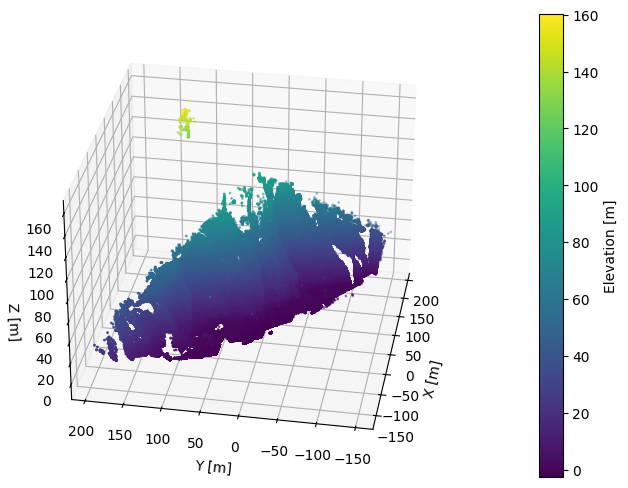

In [24]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": "3d"}, figsize=(7, 5))
scatter = ax.scatter(x[::nth], y[::nth], z[::nth], c=z[::nth], cmap='viridis', s=1, marker='o')

ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.set_zlabel("Z [m]")
ax.view_init(elev=30.0, azim=190.0)

cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label("Elevation [m]")

plt.tight_layout()
plt.savefig(f"{log_dir}/PC_Raw.png", dpi=300, bbox_inches="tight")
plt.show()

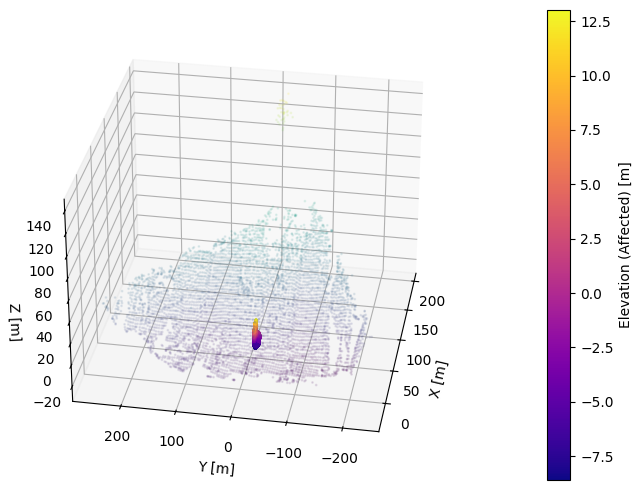

In [25]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": "3d"}, figsize=(7, 5))

tem_points = np.vstack((x_trans[~mask][::nth], y_trans[~mask][::nth], z_trans[~mask][::nth])).transpose()

unaffected_alter_pcd        = o3d.geometry.PointCloud()
unaffected_alter_pcd.points = o3d.utility.Vector3dVector(tem_points)
unaffected_alter_pcd        = unaffected_alter_pcd.voxel_down_sample(voxel_size=4)
unaffected_alter_ds         = np.asarray(unaffected_alter_pcd.points)

scatter_unaffected = ax.scatter(
    unaffected_alter_ds[:, 0],
    unaffected_alter_ds[:, 1],
    unaffected_alter_ds[:, 2],
    c=unaffected_alter_ds[:, 2],
    cmap="viridis",
    s=1,
    marker="o",
    alpha=0.1,
)
scatter_affected = ax.scatter(
    x_trans[mask][::nth],
    y_trans[mask][::nth],
    z_trans[mask][::nth],
    c=z_trans[mask][::nth],
    cmap="plasma",
    s=1,
    marker="o",
)

ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.set_zlabel("Z [m]")
ax.view_init(elev=30.0, azim=190.0)

cbar = plt.colorbar(scatter_affected, ax=ax, pad=0.1)
cbar.set_label("Elevation (Affected) [m]")

plt.tight_layout()
plt.savefig(f"{log_dir}/PC_Alt.png", dpi=300, bbox_inches="tight")
plt.show()

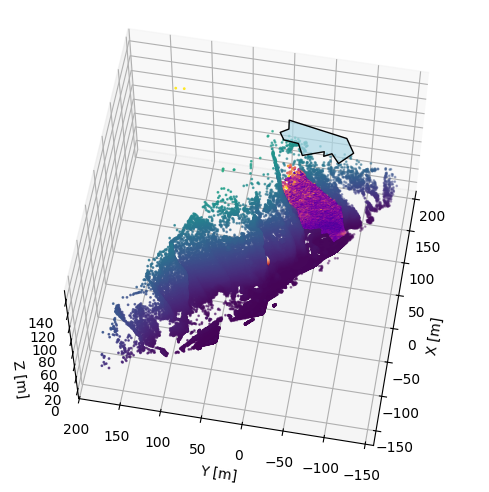

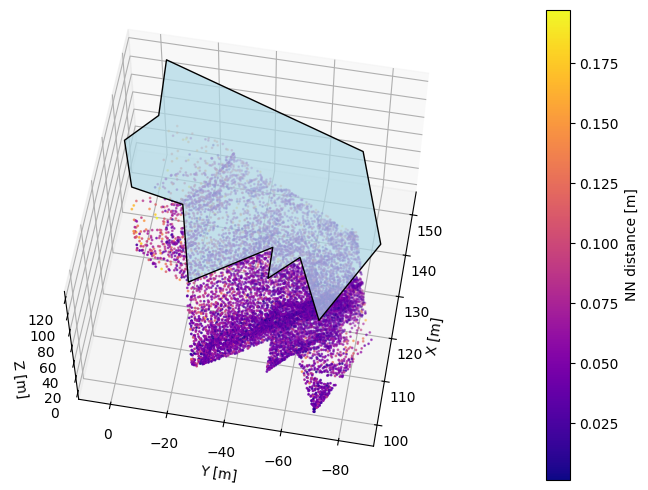

In [26]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": "3d"}, figsize=(7, 5))

all_x, all_y, all_z = [], [], []
for geom in satble_shp.geometry:
    if geom is None:
        print("Skipping missing geometry")
        continue

    def process_polygon(poly):
        coords = list(poly.exterior.coords)
        if len(coords[0]) == 3:
            xs, ys, zs = zip(*coords)
        else:
            xs, ys = zip(*coords)
            zs = [120] * len(xs)  # Arbitrary height if not present
        all_x.extend(xs)
        all_y.extend(ys)
        all_z.extend(zs)

        verts = [list(zip(xs, ys, zs))]
        poly3d = Poly3DCollection(
            verts, facecolor="lightblue", edgecolor="black", alpha=0.7
        )
        ax.add_collection3d(poly3d)

    if geom.geom_type == "MultiPolygon":
        for poly in geom.geoms:
            process_polygon(poly)
    elif geom.geom_type == "Polygon":
        process_polygon(geom)

combined_mask = (~mask) & mask_after

scatter_unaffe = ax.scatter(
    x_refined[combined_mask][::100],
    y_refined[combined_mask][::100],
    z_refined[combined_mask][::100],
    c=z_refined[combined_mask][::100],
    cmap="viridis",
    s=1,
    marker="o",
)
scatter_affect = ax.scatter(
    x_refined[mask][::100],
    y_refined[mask][::100],
    z_refined[mask][::100],
    c=z_refined[mask][::100],
    cmap="RdBu",
    s=1,
    marker="o",
)
scatter_stable = ax.scatter(
    stable_before[::100, 0],
    stable_before[::100, 1],
    stable_before[::100, 2],
    c=distances[::100],
    cmap="plasma",
    s=1,
    marker="o",
)

ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.set_zlabel("Z [m]")
ax.view_init(elev=60.0, azim=190.0)

plt.tight_layout()
plt.savefig(f"{log_dir}/PC_stable_rel.png", dpi=300, bbox_inches="tight")
plt.show()

fig, ax = plt.subplots(1, 1, subplot_kw={"projection": "3d"}, figsize=(7, 5))

all_x, all_y, all_z = [], [], []
for geom in satble_shp.geometry:
    if geom is None:
        print("Skipping missing geometry")
        continue

    def process_polygon(poly):
        coords = list(poly.exterior.coords)
        if len(coords[0]) == 3:
            xs, ys, zs = zip(*coords)
        else:
            xs, ys = zip(*coords)
            zs = [120] * len(xs) # Arbitrary height if not present
        all_x.extend(xs)
        all_y.extend(ys)
        all_z.extend(zs)

        verts = [list(zip(xs, ys, zs))]
        poly3d = Poly3DCollection(
            verts, facecolor="lightblue", edgecolor="black", alpha=0.7
        )
        ax.add_collection3d(poly3d)

    if geom.geom_type == "MultiPolygon":
        for poly in geom.geoms:
            process_polygon(poly)
    elif geom.geom_type == "Polygon":
        process_polygon(geom)

combined_mask = (~mask) & mask_after

scatter_stable = ax.scatter(
    stable_before[::100, 0],
    stable_before[::100, 1],
    stable_before[::100, 2],
    c=distances[::100],
    cmap="plasma",
    s=1,
    marker="o",
)

ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.set_zlabel("Z [m]")
ax.view_init(elev=60.0, azim=190.0)

cbar = fig.colorbar(scatter_stable, ax=ax, pad=0.1)
cbar.set_label("NN distance [m]")

plt.tight_layout()
plt.savefig(f"{log_dir}/PC_stable_isolate.png", dpi=300, bbox_inches="tight")
plt.show()

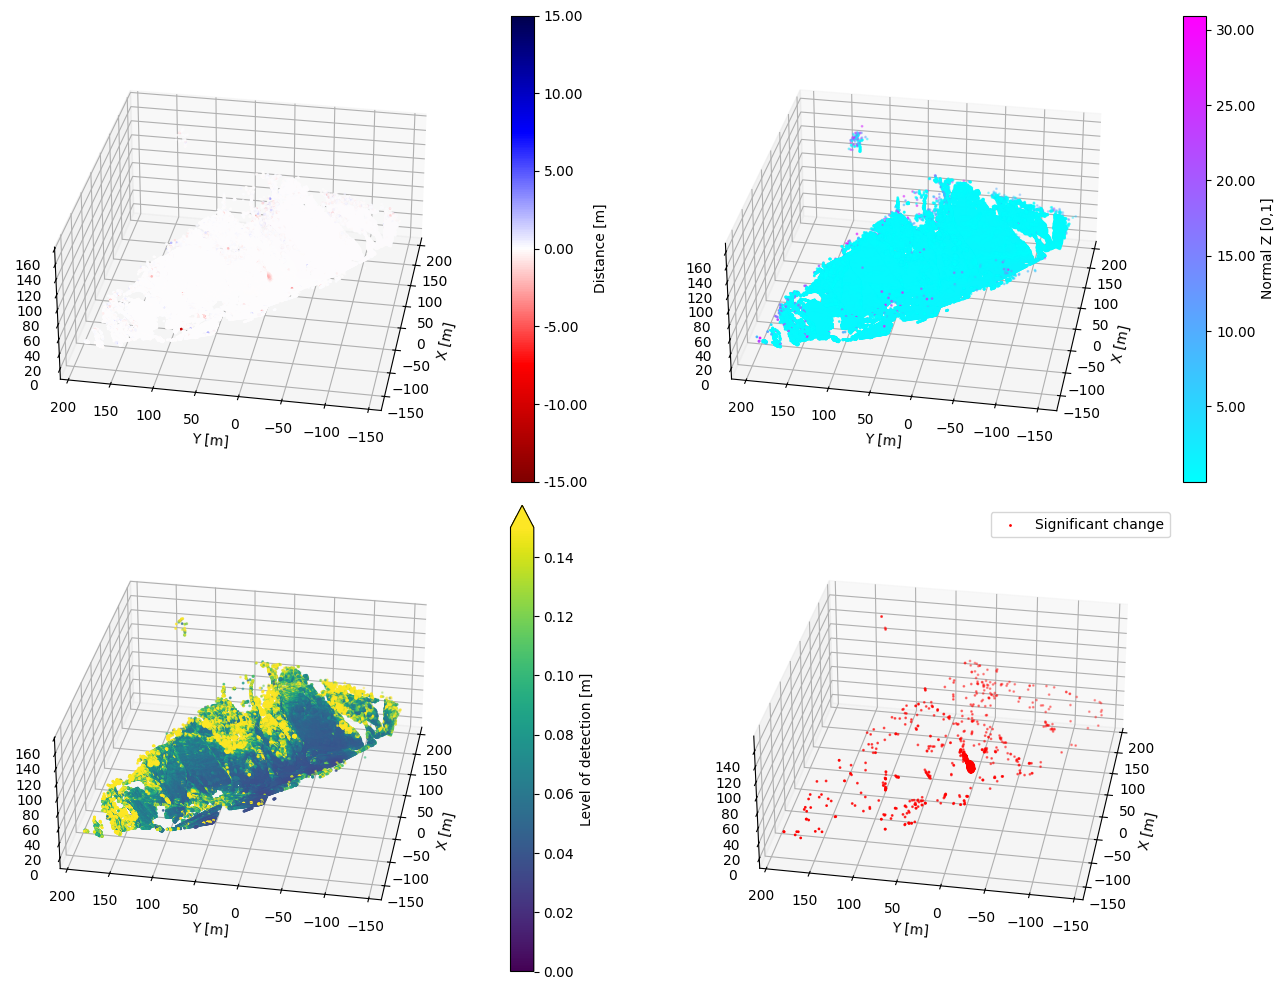

In [27]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10), subplot_kw={"projection": "3d"})
(ax1, ax2), (ax3, ax4) = axs

# Plot the distances
d = ax1.scatter(
    corepoints[:, 0],
    corepoints[:, 1],
    corepoints[:, 2],
    c=m3c2_distances,
    cmap="seismic_r",
    vmin=-15.0,
    vmax=15.0,
    s=1,
    marker='*',
)
plt.colorbar(d, format=("%.2f"), label="Distance [m]", ax=ax1)

# Plot the directions
directions = m3c2.directions()
dz = ax2.scatter(
    corepoints[:, 0],
    corepoints[:, 1],
    corepoints[:, 2],
    c=directions[:, 2],
    cmap="cool",
    s=1,
)
plt.colorbar(dz, format=("%.2f"), label="Normal Z [0,1]", ax=ax2)

# Plot the level of detection values
l = ax3.scatter(
    corepoints[:, 0],
    corepoints[:, 1],
    corepoints[:, 2],
    c=uncertainties["lodetection"],
    cmap="viridis",
    vmin=0.0,
    vmax=0.15,
    s=1,
)
plt.colorbar(
    l,
    format=("%.2f"),
    label="Level of detection [m]",
    ax=ax3,
    extend="max",
)

# Plot the significant change values (boolean)
ax4.scatter(
    corepoints[change_sign][:, 0],
    corepoints[change_sign][:, 1],
    corepoints[change_sign][:, 2],
    label="Significant change",
    c="red",
    s=1,
)
ax4.legend()

# Add plot elements
for ax_set in axs:
    for ax in ax_set:
        ax.set_xlabel("X [m]")
        ax.set_ylabel("Y [m]")
        ax.set_aspect("equal")
        ax.view_init(elev=30.0, azim=190.0)

plt.axis("equal")
plt.tight_layout()
plt.savefig(f"{log_dir}/PC_changedet.png", dpi=300, bbox_inches="tight")
plt.show()

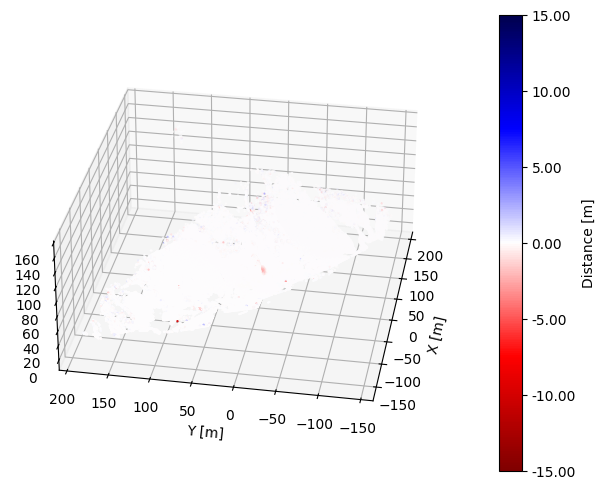

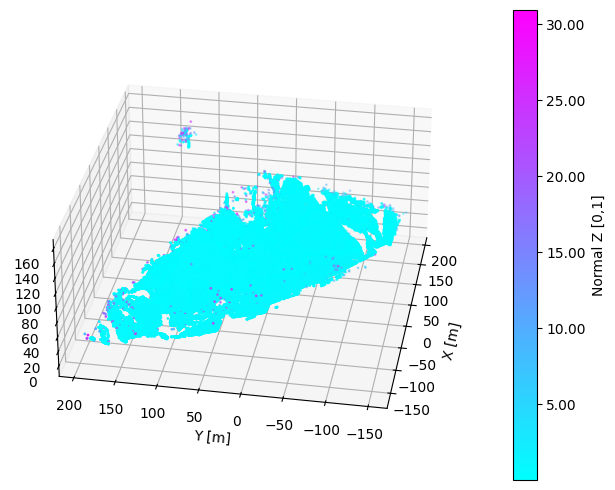

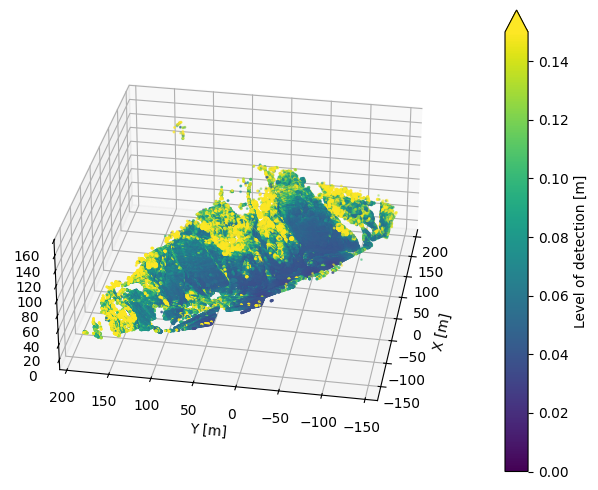

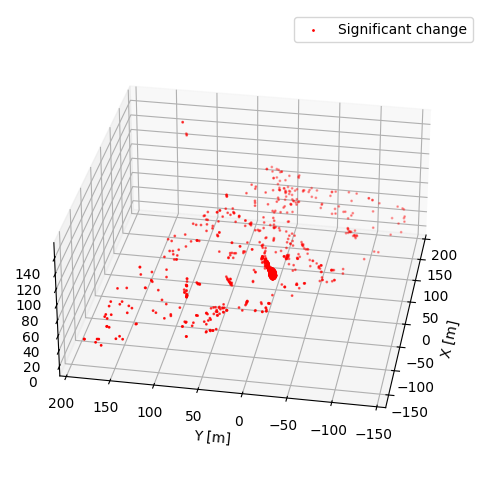

In [28]:
# Plot 1: Distances
fig1 = plt.figure(figsize=(7, 5))
ax1 = fig1.add_subplot(111, projection="3d")
d = ax1.scatter(
    corepoints[:, 0],
    corepoints[:, 1],
    corepoints[:, 2],
    c=m3c2_distances,
    cmap="seismic_r",
    vmin=-15.0,
    vmax=15.0,
    s=1,
    marker='.',
)
plt.colorbar(d, format="%.2f", label="Distance [m]", ax=ax1)
ax1.set_xlabel("X [m]")
ax1.set_ylabel("Y [m]")
ax1.set_aspect("equal")
ax1.view_init(elev=30.0, azim=190.0)
plt.axis("equal")
plt.tight_layout()
plt.savefig(f"{log_dir}/PC_changedet_distance.png", dpi=800, bbox_inches="tight")
plt.show()

# Plot 2: Directions
fig2 = plt.figure(figsize=(7, 5))
ax2 = fig2.add_subplot(111, projection="3d")
directions = m3c2.directions()
dz = ax2.scatter(
    corepoints[:, 0],
    corepoints[:, 1],
    corepoints[:, 2],
    c=directions[:, 2],
    cmap="cool",
    s=1,
)
plt.colorbar(dz, format="%.2f", label="Normal Z [0,1]", ax=ax2)
ax2.set_xlabel("X [m]")
ax2.set_ylabel("Y [m]")
ax2.set_aspect("equal")
ax2.view_init(elev=30.0, azim=190.0)
plt.axis("equal")
plt.tight_layout()
plt.savefig(f"{log_dir}/PC_changedet_directions.png", dpi=300, bbox_inches="tight")
plt.show()

# Plot 3: Level of Detection
fig3 = plt.figure(figsize=(7, 5))
ax3 = fig3.add_subplot(111, projection="3d")
l = ax3.scatter(
    corepoints[:, 0],
    corepoints[:, 1],
    corepoints[:, 2],
    c=uncertainties["lodetection"],
    cmap="viridis",
    vmin=0.0,
    vmax=0.15,
    s=1,
)
plt.colorbar(l, format="%.2f", label="Level of detection [m]", ax=ax3, extend="max")
ax3.set_xlabel("X [m]")
ax3.set_ylabel("Y [m]")
ax3.set_aspect("equal")
ax3.view_init(elev=30.0, azim=190.0)
plt.axis("equal")
plt.tight_layout()
plt.savefig(f"{log_dir}/PC_changedet_detection.png", dpi=300, bbox_inches="tight")
plt.show()

# Plot 4: Significant Change (Boolean)
fig4 = plt.figure(figsize=(7, 5))
ax4 = fig4.add_subplot(111, projection="3d")
ax4.scatter(
    corepoints[change_sign][:, 0],
    corepoints[change_sign][:, 1],
    corepoints[change_sign][:, 2],
    label="Significant change",
    c="red",
    s=1,
)
ax4.legend()
ax4.set_xlabel("X [m]")
ax4.set_ylabel("Y [m]")
ax4.set_aspect("equal")
ax4.view_init(elev=30.0, azim=190.0)
plt.axis("equal")
plt.tight_layout()
plt.savefig(f"{log_dir}/PC_changedet_significant.png", dpi=300, bbox_inches="tight")
plt.show()

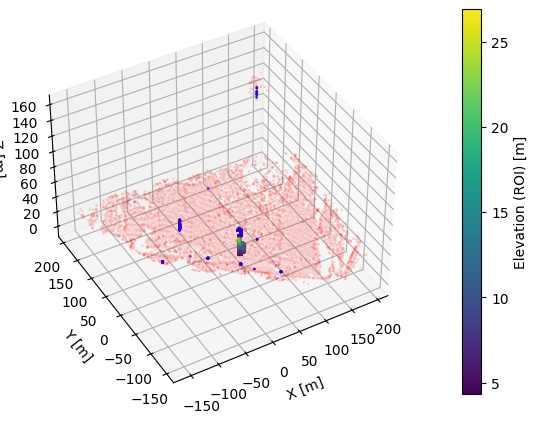

In [29]:
unselected_hulls = [
    hulls[i] for i in range(len(hulls)) if i not in selected_indices
]
inside_nonroi_raw = pipeline.is_inside_selected_hulls_vectorized(
    unselected_hulls, target[:, :2]
)

mask_combined = np.logical_and(~inside_nonroi_raw, ~inside_mask_raw)
unfiltered_raw = target[mask_combined]

filtered_raw_nonroi   = target[inside_nonroi_raw]
filtered_raw_nonroi_x = filtered_raw_nonroi[:, 0]
filtered_raw_nonroi_y = filtered_raw_nonroi[:, 1]
filtered_raw_nonroi_z = filtered_raw_nonroi[:, 2]

fig, ax = plt.subplots(1, 1, subplot_kw={"projection": "3d"}, figsize=(7, 5))

unfiltered_raw_pcd        = o3d.geometry.PointCloud()
unfiltered_raw_pcd.points = o3d.utility.Vector3dVector(unfiltered_raw)
unfiltered_raw_pcd        = unfiltered_raw_pcd.voxel_down_sample(voxel_size=4)
unfiltered_raw_ds         = np.asarray(unfiltered_raw_pcd.points)

unfiltered_raw_x = unfiltered_raw_ds[:, 0]
unfiltered_raw_y = unfiltered_raw_ds[:, 1]
unfiltered_raw_z = unfiltered_raw_ds[:, 2]

scatter_unaffected = ax.scatter(
    filtered_raw_x[::1],
    filtered_raw_y[::1],
    filtered_raw_z[::1],
    c=filtered_raw_z[::1],
    cmap="viridis",
    s=1,
    marker="o",
)
scatter_affected = ax.scatter(
    unfiltered_raw_x[::1],
    unfiltered_raw_y[::1],
    unfiltered_raw_z[::1],
    c="red",
    s=1,
    marker="o",
    alpha=0.1,
)
scatter_unselect = ax.scatter(
    filtered_raw_nonroi_x[::1],
    filtered_raw_nonroi_y[::1],
    filtered_raw_nonroi_z[::1],
    c="blue",
    s=1,
    marker="o",
)

ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.set_zlabel("Z [m]")
ax.view_init(elev=40.0, azim=240.0)

cbar = plt.colorbar(scatter_unaffected, ax=ax, pad=0.1)
cbar.set_label("Elevation (ROI) [m]")

plt.savefig(f"{log_dir}/ROI.png", dpi=300, bbox_inches="tight")
plt.show()

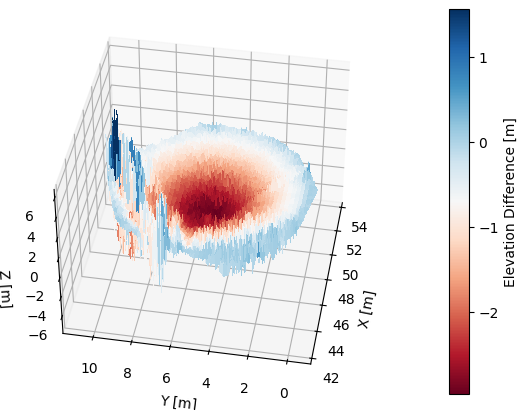

In [30]:
diff_masked = np.ma.masked_invalid(diff_DEMs)

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection="3d")

surf = ax.plot_surface(
    dem_grid_x, dem_grid_y, diff_masked, cmap="RdBu", linewidth=0, antialiased=False
)

fig.colorbar(surf, ax=ax, pad=0.1, label="Elevation Difference [m]")

ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.set_zlabel("Z [m]")
ax.view_init(elev=40.0, azim=190.0)

plt.savefig(f"{log_dir}/PC_DEM_3D.png", dpi=300, bbox_inches="tight")
plt.show()